In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [104]:
#import pandas as pd

# Load the dataset
#df = pd.read_csv('datasetforclassification_updatedd_updated_updated_updated1.csv', encoding='latin1')

# Drop rows with nan values in 'Base_Reviews' and 'My_Labels' columns
#df = df.dropna(subset=['Base_Reviews', 'My_Labels'])

# Save the cleaned dataset
#df.to_csv('datasetforclassification_updatedd_updated_updated_updated12.csv', index=False, encoding='latin1')


In [105]:
# Load the dataset
df = pd.read_csv('chatgptannoated_datset_finalll.csv', encoding='latin1')

In [106]:
# Preprocessing the text data
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Define a function to clean the text
def clean_text(text):
    # Check if the input is a string, if not return as is
    if not isinstance(text, str):
        return text
    
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Apply the clean_text function to the text column
X_clean = df['Base_Reviews'].apply(clean_text)

In [107]:
# Split the dataset into X and y
X = df['Base_Reviews'].values
y = df['category'].values


In [108]:


y_dict = {'anger': 0, 'confusion': 1, 'disappointment':2, 'distrust':3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = [y_dict[item] for item in y]


In [109]:
# Convert the labels to categorical variables
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

In [110]:
# Tokenize the data
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [111]:
# Pad the sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

In [112]:
# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)


# LSTM Model

In [113]:
#Define the LSTM model
lstm_model = keras.models.Sequential()
lstm_model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
lstm_model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dense(num_classes, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
lstm_model.summary()




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 128)          256000    
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 8)                 520       
                                                                 
Total params: 396360 (1.51 MB)
Trainable params: 396360 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# BiLSTM Model

In [114]:
# Define the BiLSTM model
bilstm_model = keras.models.Sequential()
bilstm_model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
bilstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(keras.layers.Dense(64, activation='relu'))
bilstm_model.add(keras.layers.Dense(num_classes, activation='softmax'))
bilstm_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 128)          256000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 8)                 520       
                                                                 
Total params: 536136 (2.05 MB)
Trainable params: 536136 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
# Perform k-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

lstm_acc_scores = []
bilstm_acc_scores = []

In [116]:
for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

In [117]:
# Train the LSTM model on the current fold
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
lstm_acc_scores.append(lstm_acc)


                        

In [118]:
# Train the BiLSTM model on the current fold
bilstm_history = bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
bilstm_acc_scores.append(bilstm_acc)

# Calculate the average accuracy scores across the k-fold cross-validation
avg_lstm_acc = np.mean(lstm_acc_scores)
avg_bilstm_acc = np.mean(bilstm_acc_scores)



In [119]:
print("LSTM: Average Accuracy = {:.2f}".format(avg_lstm_acc))
print("BiLSTM: Average Accuracy = {:.2f}".format(avg_bilstm_acc))

# Confusion Matrix
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)

lstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), lstm_pred)
bilstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), bilstm_pred)




LSTM: Average Accuracy = 0.91
BiLSTM: Average Accuracy = 0.91
140/140 [==============================] - 12s 80ms/step


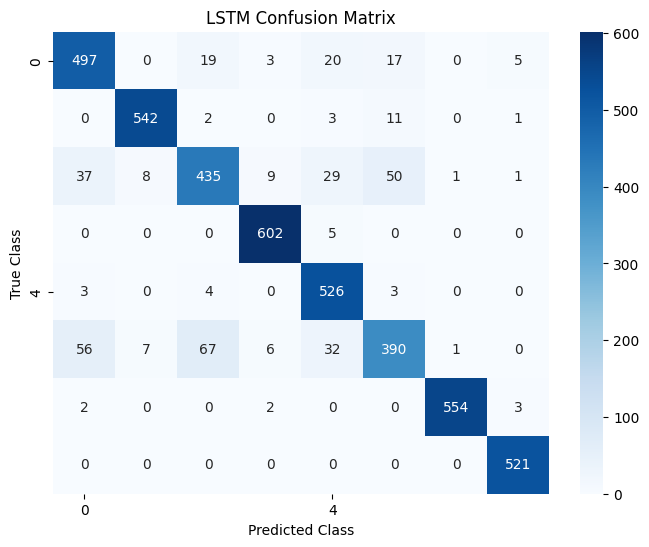

In [120]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()



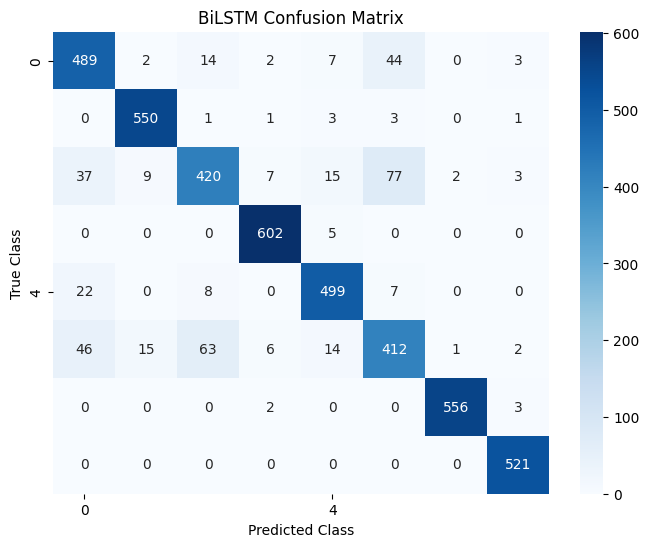

In [121]:
plt.figure(figsize=(8, 6))
sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
plt.title('BiLSTM Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

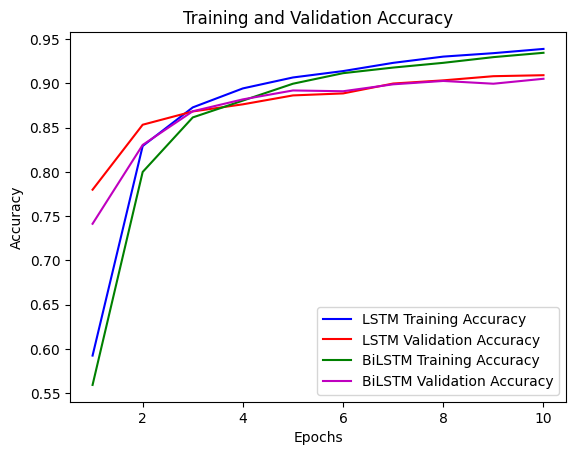

In [122]:
# Accuracy Graph
epochs = range(1, len(lstm_history.history['accuracy']) + 1)

plt.plot(epochs, lstm_history.history['accuracy'], 'b', label='LSTM Training Accuracy')
plt.plot(epochs, lstm_history.history['val_accuracy'], 'r', label='LSTM Validation Accuracy')
plt.plot(epochs, bilstm_history.history['accuracy'], 'g', label='BiLSTM Training Accuracy')
plt.plot(epochs, bilstm_history.history['val_accuracy'], 'm', label='BiLSTM Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


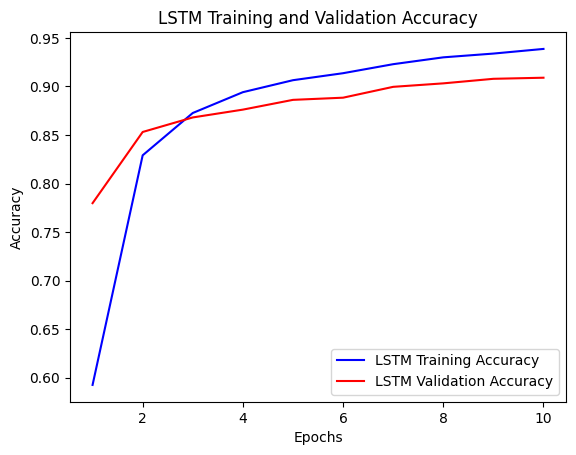

In [123]:
# LSTM Accuracy Graph
epochs = range(1, len(lstm_history.history['accuracy']) + 1)

plt.plot(epochs, lstm_history.history['accuracy'], 'b', label='LSTM Training Accuracy')
plt.plot(epochs, lstm_history.history['val_accuracy'], 'r', label='LSTM Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


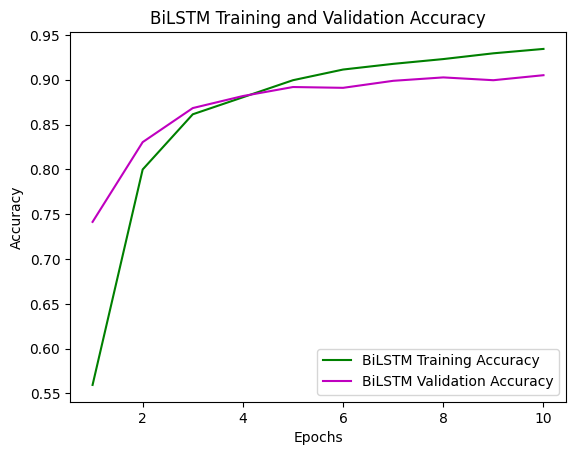

In [124]:
# BiLSTM Accuracy Graph
epochs = range(1, len(bilstm_history.history['accuracy']) + 1)

plt.plot(epochs, bilstm_history.history['accuracy'], 'g', label='BiLSTM Training Accuracy')
plt.plot(epochs, bilstm_history.history['val_accuracy'], 'm', label='BiLSTM Validation Accuracy')
plt.title('BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [125]:

# Calculate precision, recall, and F1-score for LSTM
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
lstm_report = classification_report(np.argmax(y_test, axis=-1), lstm_pred)
print("LSTM Classification Report:")
print(lstm_report)




140/140 [==============================] - 6s 40ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       561
           1       0.97      0.97      0.97       559
           2       0.83      0.76      0.79       570
           3       0.97      0.99      0.98       607
           4       0.86      0.98      0.91       536
           5       0.83      0.70      0.76       559
           6       1.00      0.99      0.99       561
           7       0.98      1.00      0.99       521

    accuracy                           0.91      4474
   macro avg       0.91      0.91      0.91      4474
weighted avg       0.91      0.91      0.91      4474



In [126]:
# Calculate precision, recall, and F1-score for BiLSTM
bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)
bilstm_report = classification_report(np.argmax(y_test, axis=-1), bilstm_pred)
print("BiLSTM Classification Report:")
print(bilstm_report)
                       

140/140 [==============================] - 11s 80ms/step
BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       561
           1       0.95      0.98      0.97       559
           2       0.83      0.74      0.78       570
           3       0.97      0.99      0.98       607
           4       0.92      0.93      0.92       536
           5       0.76      0.74      0.75       559
           6       0.99      0.99      0.99       561
           7       0.98      1.00      0.99       521

    accuracy                           0.91      4474
   macro avg       0.90      0.91      0.90      4474
weighted avg       0.90      0.91      0.90      4474



In [127]:
   
    # Train the LSTM model on the current fold
    lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
    lstm_acc_scores.append(lstm_acc)
    

In [128]:
    
    # Train the BiLSTM model on the current fold
    bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
    bilstm_acc_scores.append(bilstm_acc)

In [129]:
# for train_index, test_index in kf.split(X_resampled):
#     X_train, X_test = X_resampled[train_index], X_resampled[test_index]
#     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
#     # Train the LSTM model on the current fold
#     lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
#     lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
#     lstm_acc_scores.append(lstm_acc)
    
#     # Train the BiLSTM model on the current fold
#     bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
#     bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
#     bilstm_acc_scores.append(bilstm_acc)

In [130]:
# Calculate the average accuracy scores across the k-fold cross-validation
avg_lstm_acc = np.mean(lstm_acc_scores)
avg_bilstm_acc = np.mean(bilstm_acc_scores)

In [131]:
print("LSTM: Average Accuracy = {:.2f}".format(avg_lstm_acc))
print("BiLSTM: Average Accuracy = {:.2f}".format(avg_bilstm_acc))


LSTM: Average Accuracy = 0.92
BiLSTM: Average Accuracy = 0.91


In [132]:
# Confusion Matrix
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)

lstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), lstm_pred)
bilstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), bilstm_pred)


140/140 [==============================] - 5s 39ms/step


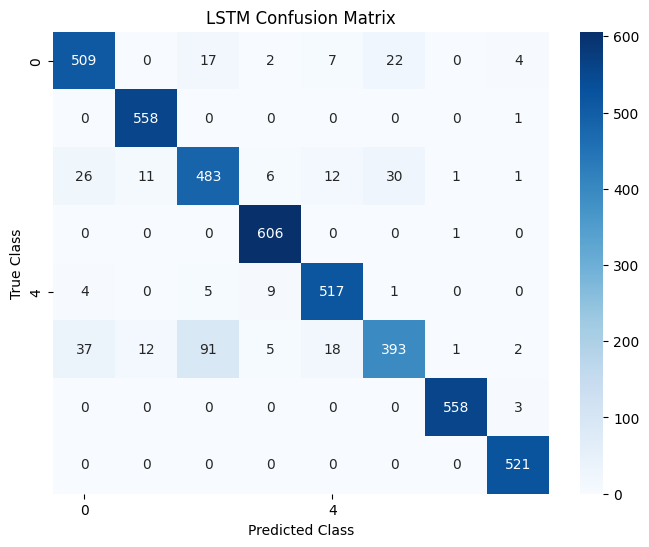

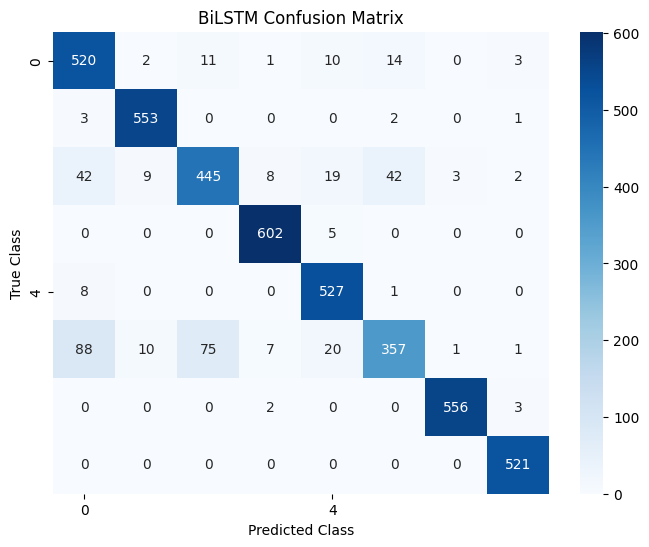

In [133]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
plt.title('BiLSTM Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [134]:
# Calculate the ROC curve and AUC for each class
n_classes = y_test.shape[1]

# For LSTM model
lstm_y_score = lstm_model.predict(X_test)
lstm_fpr = dict()
lstm_tpr = dict()
lstm_roc_auc = dict()

# For BiLSTM model
bilstm_y_score = bilstm_model.predict(X_test)
bilstm_fpr = dict()
bilstm_tpr = dict()
bilstm_roc_auc = dict()

for i in range(n_classes):
    lstm_fpr[i], lstm_tpr[i], _ = roc_curve(y_test[:, i], lstm_y_score[:, i])
    lstm_roc_auc[i] = auc(lstm_fpr[i], lstm_tpr[i])
    
    bilstm_fpr[i], bilstm_tpr[i], _ = roc_curve(y_test[:, i], bilstm_y_score[:, i])
    bilstm_roc_auc[i] = auc(bilstm_fpr[i], bilstm_tpr[i])



140/140 [==============================] - 5s 39ms/step


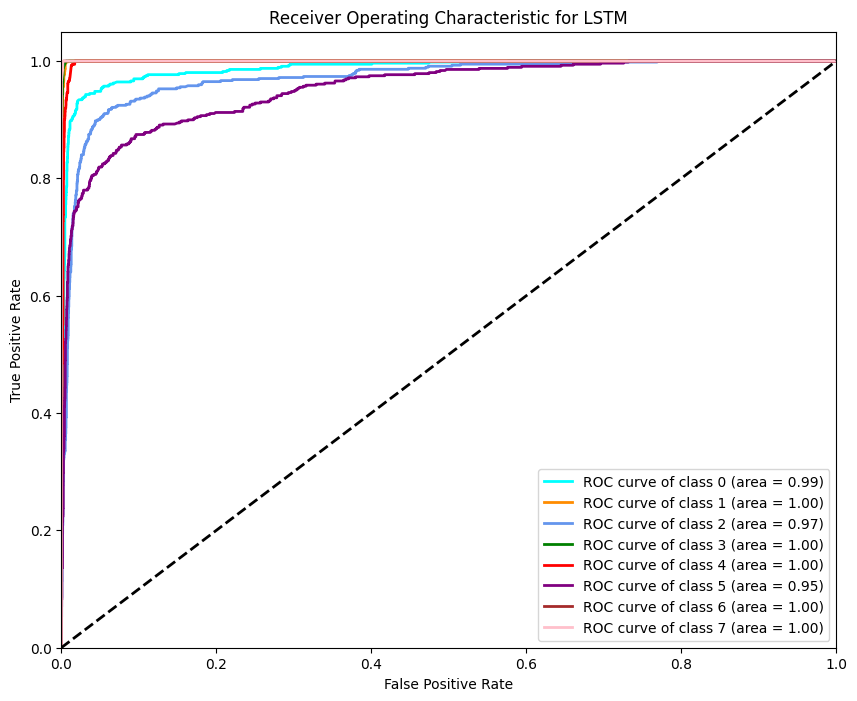

In [135]:
# Plot the ROC curve for LSTM model
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(lstm_fpr[i], lstm_tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, lstm_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM')
plt.legend(loc="lower right")
plt.show()



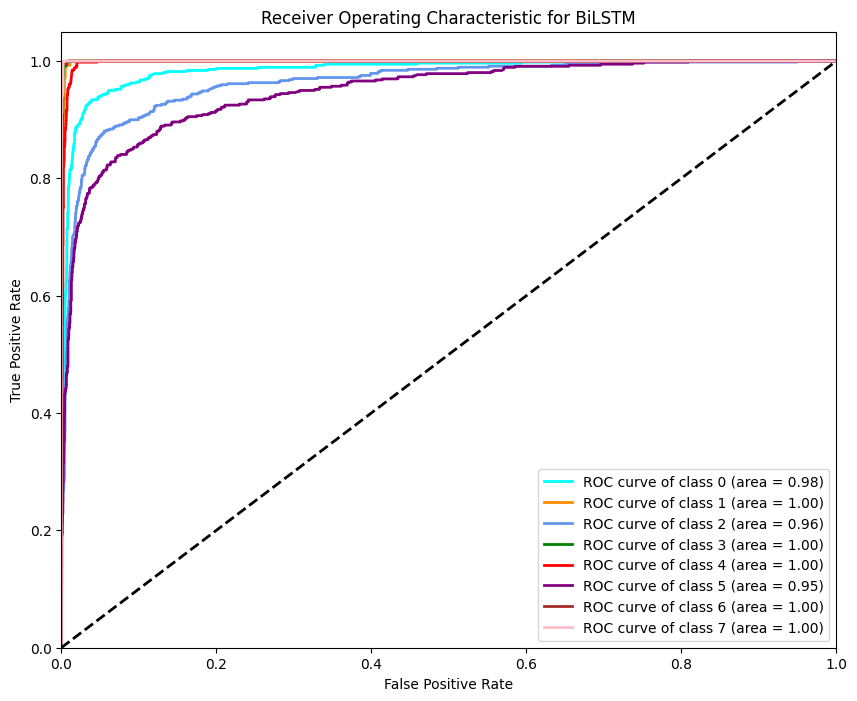

In [136]:
# Plot the ROC curve for BiLSTM model
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(bilstm_fpr[i], bilstm_tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, bilstm_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiLSTM')
plt.legend(loc="lower right")
plt.show()

In [137]:
    

# # Calculate the average accuracy scores across the k-fold cross-validation
# avg_lstm_acc = np.mean(lstm_acc_scores)
# avg_bilstm_acc = np.mean(bilstm_acc_scores)

# print("LSTM: Average Accuracy = {:.2f}".format(avg_lstm_acc))
# print("BiLSTM: Average Accuracy = {:.2f}".format(avg_bilstm_acc))

# # Confusion Matrix
# lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
# bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)

# lstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), lstm_pred)
# bilstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), bilstm_pred)

# # Confusion Matrix Visualization
# plt.figure(figsize=(8, 6))
# sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
# plt.title('LSTM Confusion Matrix')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
# plt.title('BiLSTM Confusion Matrix')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.show()

# # Accuracy Graph
# epochs = range(1, len(lstm_history.history['accuracy']) + 1)

# plt.plot(epochs, lstm_history.history['accuracy'], 'b', label='LSTM Training Accuracy')
# plt.plot(epochs, lstm_history.history['val_accuracy'], 'r', label='LSTM Validation Accuracy')
# plt.plot(epochs, bilstm_history.history['accuracy'], 'g', label='BiLSTM Training Accuracy')
# plt.plot(epochs, bilstm_history.history['val_accuracy'], 'm', label='BiLSTM Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Calculate precision, recall, and F1-score for LSTM
# lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
# lstm_report = classification_report(np.argmax(y_test, axis=-1), lstm_pred)
# print("LSTM Classification Report:")
# print(lstm_report)

# # Calculate precision, recall, and F1-score for BiLSTM
# bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)
# bilstm_report = classification_report(np.argmax(y_test, axis=-1), bilstm_pred)
# print("BiLSTM Classification Report:")
# print(bilstm_report)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 128)          256000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 8)                 520       
                                                                 
Total params: 297672 (1.14 MB)
Trainable params: 297672 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
RNN: Average Accuracy = 0.86
239/239 [==============================] - 1s 5ms/step


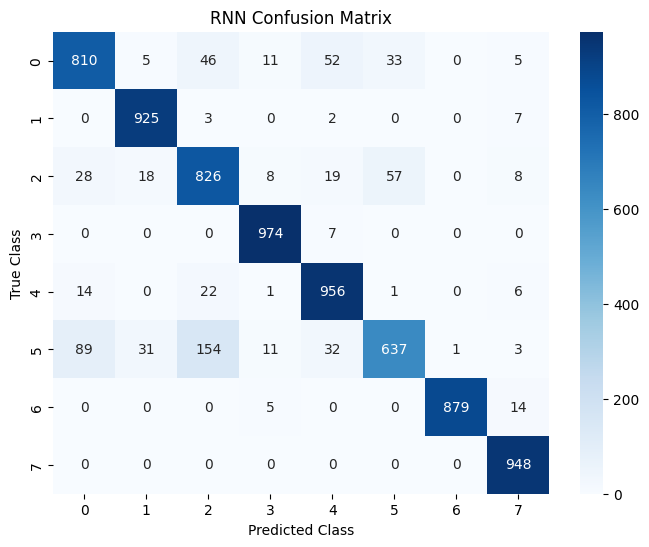

239/239 [==============================] - 1s 4ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       962
           1       0.94      0.99      0.97       937
           2       0.79      0.86      0.82       964
           3       0.96      0.99      0.98       981
           4       0.90      0.96      0.92      1000
           5       0.88      0.66      0.76       958
           6       1.00      0.98      0.99       898
           7       0.96      1.00      0.98       948

    accuracy                           0.91      7648
   macro avg       0.91      0.91      0.91      7648
weighted avg       0.91      0.91      0.91      7648



In [138]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

# Load the dataset
df = pd.read_csv('Introduction_chatgptdataset.csv', encoding='latin1')

# Preprocessing the text data
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define a function to clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Handle missing or unexpected values in the 'My_Labels' column
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
df = df[df['category'].isin(y_dict.keys())]

# Apply the clean_text function to the text column
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

# Split the dataset into X and y after cleaning and filtering
X = df['Base_Reviews'].values
y = [y_dict[item] for item in df['category'].values]

# Convert the labels to categorical variables
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

# Tokenize the data
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad the sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Define the RNN model
rnn_model = keras.models.Sequential()
rnn_model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
rnn_model.add(keras.layers.SimpleRNN(128, dropout=0.4, recurrent_dropout=0.4))
rnn_model.add(keras.layers.Dense(64, activation='relu'))
rnn_model.add(keras.layers.Dense(num_classes, activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
rnn_model.summary()

# Perform k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
rnn_acc_scores = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
    rnn_acc_scores.append(rnn_acc)

avg_rnn_acc = np.mean(rnn_acc_scores)
print("RNN: Average Accuracy = {:.2f}".format(avg_rnn_acc))

# Confusion Matrix
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=-1)
rnn_cm = confusion_matrix(np.argmax(y_test, axis=-1), rnn_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Accuracy Graph
#epochs = range(1, len(rnn_history.history['accuracy']) + 1)
#plt.plot(epochs, rnn_history.history['accuracy'], 'b', label='RNN Training Accuracy')
#plt.plot(epochs, rnn_history.history['val_accuracy'], 'r', label='RNN Validation Accuracy')
#plt.title('Training and Validation Accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

# Calculate precision, recall, and F1-score for RNN
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=-1)
rnn_report = classification_report(np.argmax(y_test, axis=-1), rnn_pred)
print("RNN Classification Report:")
print(rnn_report)

